In [1]:
# =============================
# FUNCTIONS for overlapping pulses 
# =============================
 
############## Bath parameters ##############
global Boltzmann, hbar, Temp
Boltzmann = 1.0
hbar = 1.0

from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import matplotlib.pyplot as plt
from qutip.solver import Result
from qutip import *
import numpy as np
import itertools
import os

# Import the outsourced plot settings
from plot_settings import *
import functions_indep as f_indep

/home/leopold/PycharmProjects/Master_thesis/code/python/functions_indep.py:1099: SyntaxWarning: invalid escape sequence '\D'
  """# =============================
/home/leopold/PycharmProjects/Master_thesis/code/python/functions_indep.py:1197: SyntaxWarning: invalid escape sequence '\s'
  """# Test the sampling function


In [8]:
# =============================
# SYSTEM PARAMETERS     (**changeable**)
# =============================
global N_atoms, ODE_Solver, omega_laser, E0, E_freqs, E_amps, omega_A, mu_eg, rabi_0, delta_rabi, Delta, RWA_laser, gamma_0, gamma_phi, Gamma
N_atoms = 1  # Set the number of atoms only works for 1
assert N_atoms == 1, "This code only works for 1 atoms"

fac_two_pi = 1 * 2 * np.pi  # Factor to convert from Hertz to angular frequency [fs^-1] -> [rads/ fs] -> also have to adjust the plotting of the 2D spectrum
RWA_laser = False  #  CAN ONLY HANDLE TRUE For MY solver (paper)   only valid for omega_laser ~ omega_A
ODE_Solver = "Paper_BR"  # "Paper_eqs" (solve the EOMs from the paper) or "Paper_BR" do d/dt rho = -i/hbar * [H0 - Dip * E, rho] + R(rho)

gamma_0 = 1/300 # (**changeable**): [1/fs] population. decay rate
T_2 = 1e2       # (**changeable**)     dephasing time
pulse_duration = 15  # [fs]
E0 = 0.01  # (**changeable*) Amplitude of the laser field -> determines Rabi freq!      excitation should be <=1%!!!


gamma_phi = 1 / T_2 #               Dephasing rate
Gamma = gamma_0/2 + gamma_phi       # total dephasing rate


### Phase Cycling for Averaging
phases = [k * np.pi / 2 for k in range(4)]
### Define Atomic States
atom_g, atom_e = basis(2, 0), basis(2, 1)  # Ground, Excited states
psi_ini = ket2dm(atom_g)  # initial state ground state
# values from the paper: [cm-1] linear wavenumber, usually used in spectroscopy
omega_laser = 16000.0 # in the middle of the two transitions
### If the excited states are coupled -> modified the energy levels
Delta = 200.0
omega_A = 16000.0
mu_eg = 1.0

### define the laser parameters
omega_laser *= fac_two_pi * 2.998 * 10**-5 #  omega = 2 pi c[10*2 cm/10*15 fs] nu_tilde: [fs⁻¹]
omega_A *= fac_two_pi * 2.998 * 10**-5
Delta *= fac_two_pi * 2.998 * 10**-5
print("omega_L, omega_A, Delta", omega_laser, omega_A, Delta)


E_freqs = [omega_laser] * 3  # Laser frequencies
E_amps = [E0, E0, 1e-1 * E0]  # third one is small to simulate a probe field

SM_op = mu_eg * (atom_g * atom_e.dag()).unit()
Dip_op = SM_op + SM_op.dag()

e_ops_list = [
    ket2dm(atom_g),
    atom_g * atom_e.dag(),
    atom_e * atom_g.dag(),
    ket2dm(atom_e),
]
e_ops_labels = ["gg", 
                "ge", 
                "eg",
                "ee"
                ]

c_ops_list = [np.sqrt(Gamma) * SM_op, np.sqrt(gamma_phi) * ket2dm(atom_e)]

# Rabi oscillation / coupling to the laser
g_value = mu_eg * E0
rabi_0 = g_value / hbar
delta_rabi = omega_laser - omega_A  # detuning from center of manifold
rabi_gen = np.sqrt(
    rabi_0**2 + delta_rabi**2
)

t_max_L = 6 * 2 * np.pi / omega_laser  # Just the six periods of the laser rotation
t_prd = 2 * np.pi / rabi_gen
fine_spacing = 0.01 * min(t_prd, pulse_duration)
t_max_r = max(200, 0.01 * t_prd)  # (**changeable**) # 5 periods of the rabi oscillation
t_max = t_max_r
Delta_ts = [pulse_duration/2] * 3
print("Period for one Rabi oscillation: T/fs  = ", t_prd)

omega_L, omega_A, Delta 3.0139183281479043 3.0139183281479043 0.037673979101848803
Period for one Rabi oscillation: T/fs  =  628.3185307179587


In [9]:
# =============================
# Synchronize all system parameters with f_indep.
# =============================
f_indep.RWA_laser = RWA_laser  # or False, as needed
f_indep.e_ops_list = e_ops_list  # or False, as needed
f_indep.e_ops_labels = e_ops_labels  # or False, as needed
f_indep.N_atoms      = N_atoms
f_indep.ODE_Solver   = ODE_Solver
f_indep.omega_laser  = omega_laser
f_indep.E0           = E0
f_indep.E_freqs      = E_freqs
f_indep.E_amps       = E_amps
f_indep.omega_A      = omega_A
f_indep.mu_eg        = mu_eg
f_indep.rabi_0       = rabi_0
f_indep.delta_rabi   = delta_rabi
f_indep.RWA_laser    = RWA_laser
f_indep.psi_ini      = psi_ini
f_indep.SM_op        = SM_op
f_indep.Dip_op       = Dip_op
f_indep.e_ops_list   = e_ops_list
f_indep.e_ops_labels = e_ops_labels
f_indep.rabi_gen     = rabi_gen
f_indep.Delta_ts     = Delta_ts

# ##########################
# dependent of system
# ##########################
def apply_RWA_phase_factors(rho, t, omega=omega_laser):
    """
    Apply time-dependent phase factors to the density matrix entries.

    Parameters:
        rho (Qobj): Density matrix (Qobj) to modify.
        omega (float): Frequency of the phase factor.
        t (float): Current time.

    Returns:
        Qobj: Modified density matrix with phase factors applied.
    """
    # Extract the density matrix as a NumPy array
    rho_array = rho.full()
    # print(rho.isherm)

    # Apply the phase factors to the specified elements
    phase_1 = np.exp(-1j * omega * t)  # e^(-i * omega * t)

    # Modify the elements
    rho_array[1, 0] *= phase_1  # rho_alpha_0 = sigma_alpha_0 * e^(-i * omega * t)
    rho_array[0, 1] *= np.conj(phase_1)
    rho_result = Qobj(rho_array, dims=rho.dims)
    # print(rho_array[0, 1], rho_array[1,0])

    #assert rho_result.isherm, "The resulting density matrix is not Hermitian."

    return rho_result
f_indep.apply_RWA_phase_factors = apply_RWA_phase_factors

def Hamilton_tls(omega_at):
    """Hamiltonain of a two-level system.

    Args:
        hbar (float): reduced Planck's constant
        omega_A (float): atomic energy 

    Returns:
        Qobj: Hamiltonian operator of the two-level system
    """
    H0 = hbar * omega_at * ket2dm(atom_e)
    if RWA_laser:
        H0 -= hbar * omega_laser * ket2dm(atom_e)

    return H0
# =============================
# "Paper_eqs" OWN ODE SOLVER
# =============================
def matrix_ODE_paper(t, args):
    """including RWA.
    Constructs the matrix L(t) for the equation drho_dt = L(t) * rho,
    where rho is the flattened density matrix.
    """
    Et = f_indep.E_pulse(t, args)
    Et_conj = np.conj(Et)

    L = np.zeros((4, 4), dtype=complex)

    # Indices for the flattened density matrix:
    # 0: rho_gg, 1: rho_ge, 2: rho_eg, 3: rho_ee

    ### Diagonals
    # --- d/dt rho_ee ---
    L[3, 3] = -gamma_0
    L[3, 1] = 1j * Et * mu_eg
    L[3, 2] = -1j * Et_conj * mu_eg
    
    # --- d/dt rho_gg ---
    #L[0, 1] = -1j * Et * mu_eg
    #L[0, 2] = 1j * Et_conj * mu_eg
    L[0, :] += -1 * np.sum(L[[3], :], axis=0) # TODO THIS IS ACTUALLY NOT THE EQ OF MOTION OF THE PAPER but it enforces trace conservation
    # print("the trace d/dt (rho_gg + rho_ee) = ", np.sum(L[[0, 3], :]), "should be 0")

    # --- d/dt rho_eg --- and  --- d/dt rho_ge ---
    L[2, 0] = 1j * Et * mu_eg
    L[2, 3] = -1j * Et * mu_eg

    L[1, :] = np.conj(L[2, :])

    L[2, 2] = -Gamma  # Decay term for coherence
    L[1, 1] = -Gamma  # Decay term for coherence

    return Qobj(L, dims=[[[2], [2]], [[2], [2]]])
def R_paper():
    """including RWA
    Constructs the Redfield Tensor R for the equation drho_dt = -i(Hrho - rho H) + R * rho,
    where rho is the flattened density matrix.
    """
    R = np.zeros((4, 4), dtype=complex)
    # Indices for the flattened density matrix:
    # 0: rho_gg, 1: rho_ge, 2: rho_eg, 3: rho_ee

    # --- d/dt rho_eg ---
    R[2, 2] = -Gamma  # Decay term for coherence
    # --- d/dt rho_ge ---
    R[1, 1] = -Gamma

    # --- d/dt rho_ee ---
    R[3, 3] = -gamma_0  # Decay term for population
    # --- d/dt rho_gg ---
    R[0, 3] =  gamma_0  # TODO THIS IS ACTUALLY NOT THE EQ OF MOTION OF THE PAPER but to ensure trace conservation

    return Qobj(R, dims=[[[2], [2]], [[2], [2]]])

def compute_pulse_evolution(psi_ini, times, curr, prev=None, preprev=None, omega_at=omega_A):
    """
    Compute the evolution of the i-th pulse starting from the current state psi_ini.
    times[0] =^= psi_ini

    Parameters:
        psi_ini (Qobj): Initial quantum state.
        times (array): Time array for the evolution.
        curr = (t0_cur, phi_curr) (tuple of floats): starting time and phase kick of the current pulse
        prev = (t0_prev, phi_prev)  (tuple of floats, optional): Start time and phase kick of the previous pulse. Defaults to None.
        preprev = (t0_preprev, phi_preprev) (tuple of floats, optional): Start time and phase kick of the first pulse. Defaults to None.
        omega_at (float): Atomic frequency for the free Hamiltonian.

    Returns:
        Qutip.Result: Result of the evolution.
    """
    # Set solver options
    progress_bar = "enhanced" if preprev != None and times[0] >= times[len(times) // 2] else ""
    options = {
        "store_states": True,
        "progress_bar": progress_bar,
    }
    
    args = f_indep.get_pulse_args(curr, prev, preprev)

    # Choose solver and compute the evolution
    if ODE_Solver != "Paper_eqs" and ODE_Solver != "ME" and ODE_Solver != "Paper_BR":
            raise ValueError(f"Unknown ODE solver: {ODE_Solver}")
    elif ODE_Solver == "Paper_eqs":
        Liouville = QobjEvo(matrix_ODE_paper, args)
        result = mesolve(
            Liouville,
            psi_ini,
            times,
            options=options,
        )
    else:
        # =============================
        # Split the evolution into two parts:
        # 1. With H_int for the pulse duration
        # 2. With H0 for the rest
        # =============================
        # Find the index where times = times[0] + 2*Delta_ts[0]
        if prev is None:
            i = 0
        elif preprev is None:
            i = 1
        else:
            i = 2
        t_pulse_end = curr[0] + 2 * Delta_ts[i] # = the start of the current pulse! + pulse duration
        idx_split = np.abs(times - t_pulse_end).argmin()

        H_free = Hamilton_tls(omega_at)
        H_int_evo = H_free + QobjEvo(f_indep.H_int, args)
        times1 = times[:idx_split]
        if times1.size == 0:
            times1 = [curr[0]]
        c_ops = []
        if ODE_Solver == "Paper_BR":
            c_ops= [R_paper()]
        elif ODE_Solver == "ME":
            c_ops= c_ops_list
            
        result = mesolve(
            H_int_evo,
            psi_ini,
            times,
            c_ops=c_ops,
            options=options,
        )

        """
        times1 = times[:idx_split]
        result1 = mesolve(
            f_indep.H_int_evo,
            psi_ini,
            times1,
            c_ops=[R_paper()],
            options=options,
        )

        # --- Second part: with H0 only ---
        # Use the last state as initial state for the second part
        psi_after_pulse = result1.states[-1]
        times2 = times[idx_split:]
        if len(times2) > 0:
            result2 = mesolve(
                H_free,
                psi_after_pulse,
                times2,
                c_ops=c_ops,
                options=options,
            )
            # Combine results
            all_states = list(result1.states) + list(result2.states)
            all_times = list(result1.times) + list(result2.times)
            options_full = options.copy()
            if "store_final_state" not in options_full:
                options_full["store_final_state"] = False
            if "store_states" not in options_full:
                options_full["store_states"] = True
            result = Result(e_ops=[], options=options_full)
            result.states = all_states
            result.times = all_times
            # Copy other attributes if needed
        else:
            result = result1"""

    return result

# Monkey-patch the module
f_indep.compute_pulse_evolution = compute_pulse_evolution

fine_spacing 1.5 [fs]
times:  -7.5 -6.0 ... 99.0 len 72
Checking 'Paper_BR' solver 


Checks passed. solver appears to be called correctly, and density matrix remains Hermitian and positive.
the evolution is actually unphisical after: inf fs


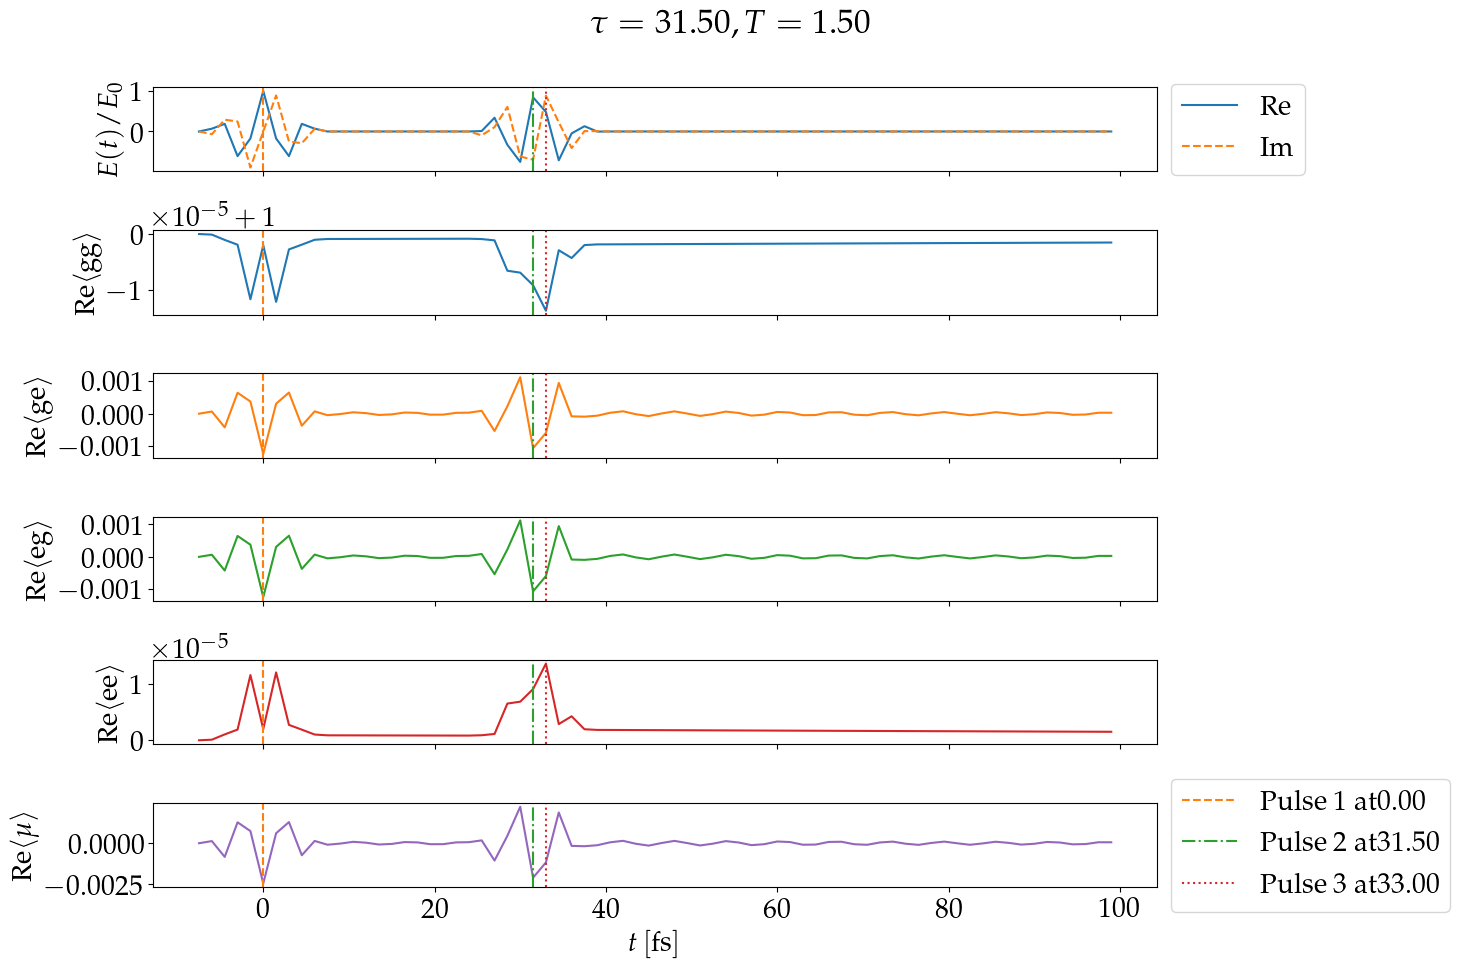

In [10]:
### Test Computation
t_max = 1*t_max_r
t_max_test     = 100 # -> determines Δω
fine_spacing_test = 10*fine_spacing # -> determines ω_max
print("fine_spacing", fine_spacing_test, "[fs]")
times_test = np.arange(-Delta_ts[0], t_max_test, fine_spacing_test)
print("times: ", times_test[0], times_test[1],"...",  times_test[-1], "len", len(times_test))

# TODO ALWAYS CHECK Before running a serious simulation
result, time_cut = f_indep.check_the_solver(psi_ini, np.arange(-Delta_ts[0], 20*t_max, 10*fine_spacing), e_ops_list)
print("the evolution is actually unphisical after:", time_cut, "fs")

T_wait_test = 1* (times_test[1]- times_test[0])
data_test_0 = f_indep.compute_two_dimensional_polarization(T_wait_test, phases[0], phases[0], times=times_test,  plot_example=True)
#data_test_1 = compute_many_polarizations(T_wait_test, phases[0], phases[0], times=times_test, N=10, E0=omega_A, Delta=Delta)

In [ ]:
plot_args_freq = dict(                   # (**changeable**) 
    space="freq",                   
    type="real",                    # plot the real part (also "imag", "phase", "abs")
    safe=False,                     # (dont) save the spectrum
    positive=True,                  # only plot the positive spectrum
    use_custom_colormap=True,       # all zeros are white
    section=(                       # focus on the non zero part
        1, 2, # xmin, xmax,
        1, 2, # ymin, ymax
        ),

    # add more options as needed
)

ts, taus, data = data_test_0[0], data_test_0[1], data_test_0[2]
#ts, taus, data, omega_samples = data_test_1[0], data_test_1[1], data_test_1[2], data_test_1[3]

extend_for = (0, 100)
ts, taus, data = f_indep.extend_time_tau_axes(ts, taus, data, pad_rows=extend_for, pad_cols=extend_for)
f_indep.plot_positive_color_map(
    (ts, taus, data),
    type="imag", # because E ~ i*P
    T_wait=T_wait_test, 
    safe=False,
    use_custom_colormap=True,
)

nu_ts, nu_taus, s2d = f_indep.compute_2d_fft_wavenumber(ts, taus, data)
f_indep.plot_positive_color_map(
    (nu_ts, nu_taus, s2d),
    T_wait=T_wait_test, 
    **plot_args_freq
)

In [ ]:
# Test the function and plot the data
t_max_test     = 1900
fine_spacing_test = 20
times_test     = np.arange(-Delta_ts[0], t_max_test, fine_spacing_test)   # High-resolution times array to do the evolutions
tau_coh_test   = 300
T_wait_test    = 1000

#plot_fixed_tau_T(tau_coh_test, T_wait_test, phases[0], phases[1], times=times_test)
plot_average_fixed_tau_T(tau_coh_test, T_wait_test, times_test, phases)

In [ ]:
# Test the function and plot the data
t_max_test     = 100 # -> determines Δω
fine_spacing_test = 0.1 # -> determines ω_max
times_test     = np.arange(-Delta_ts[0], t_max_test, fine_spacing_test)
print("times: ", times_test[0], times_test[1],"...",  times_test[-1], "len", len(times_test))
times_T_test = (np.array([0])# , 16, 30, 46, 62, 108, 140, 310])
)  # np.arange(T_wait_0, last_entry, sparse_spacing)

RESULT = parallel_process_all_combinations(phases ,times_T=times_T_test, times=times_test)

In [ ]:
# Example usage
extend_and_plot_results(RESULT, times_T=times_T_test, times=times_test, extend_for=extend_for, **plot_args_freq)